In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

from scipy.stats import lognorm

from astropy.io import ascii
import numpy as np
import astropy.units as u
import pandas as pd
from astropy.time import Time
from astropy.visualization import hist

from minicyclop.io import read_latest, read_seeing_data

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [41]:
d = read_latest(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Last_Seeing_Data.txt")

In [42]:
d['obstime'] - Time.now()

<TimeDelta object: scale='tai' format='jd' value=-0.4613419437352881>

In [43]:
filename = Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt"
dt = ascii.read(filename, delimiter='|', names=['UT', 'MST', 'JD', 'flux', 'seeing', 'r0'])

In [44]:
ut = Time(dt['JD'], scale='utc', format='jd')
ut.isot

array(['2022-06-08T03:32:32.968', '2022-06-08T03:33:27.409',
       '2022-06-08T03:34:23.655', ..., '2022-06-24T11:54:59.432',
       '2022-06-24T11:55:47.850', '2022-06-24T11:56:35.560'], dtype='<U23')

In [49]:
df = read_seeing_data(Path.home() / "MMT/minicyclop/data/MiniCyclop/Data/Seeing_Data.txt")

In [55]:
df['epoch_ms'][0], df.columns
df.to_csv("cyclop.csv")

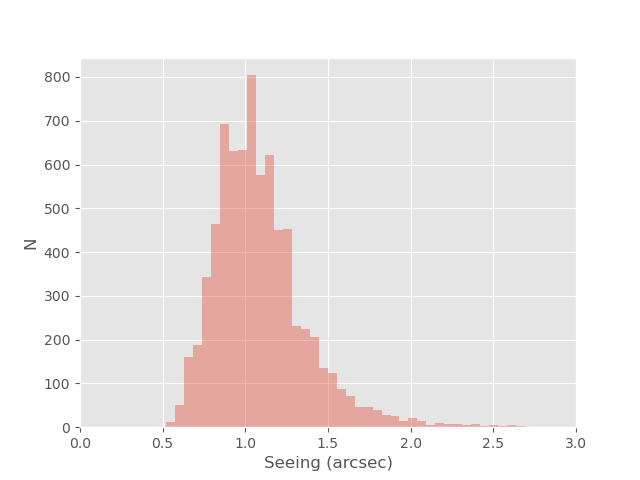

In [51]:
fig = plt.figure()
with plt.style.context('ggplot'):
    hist(df['seeing'], bins='scott', histtype='stepfilled', alpha=0.4)
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("N")
    plt.xlim([0.0, 3.0])
plt.show()

In [52]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = lognorm.fit(df['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(df['seeing'])
fit_median = exp_mu + loc

0.36861218108097543 0.3504576040815534 0.6942742251606533


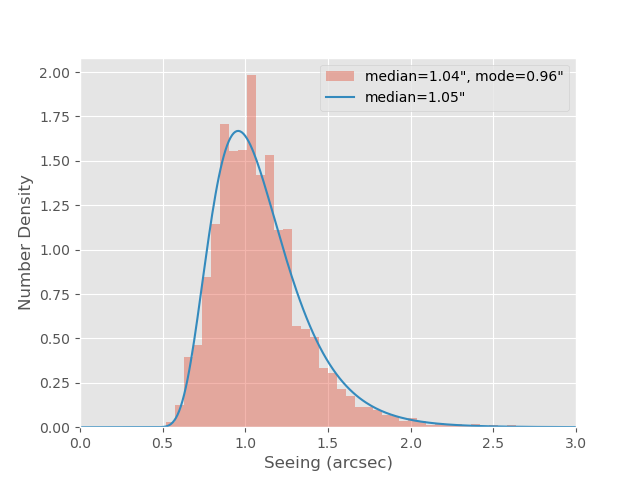

In [53]:
fig = plt.figure()
with plt.style.context('ggplot'):
    hist(df['seeing'], bins='scott', histtype='stepfilled', alpha=0.4, density=True)
    logp = plt.plot(x, p, label="logp")
    plt.xlabel("Seeing (arcsec)")
    plt.ylabel("Number Density")
    plt.xlim([0.0, 3.0])
    plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
        median
    )])
plt.show()

In [40]:
now.to_value('unix')

1656110911.899178

In [1]:
from astropy.io import fits

In [6]:
%%prun
hdul = fits.open("/home/tim/MMT/sky_brightness/mmto_sky_brightness/20191005/skyobs0084.fits")


         3253 function calls (3207 primitive calls) in 0.004 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    0.000    0.000 {built-in method io.open}
        1    0.000    0.000    0.000    0.000 {built-in method posix.stat}
        6    0.000    0.000    0.000    0.000 {method 'read' of '_io.BufferedReader' objects}
        7    0.000    0.000    0.000    0.000 {method 'seek' of '_io.BufferedReader' objects}
        1    0.000    0.000    0.001    0.001 header.py:340(fromstring)
       78    0.000    0.000    0.000    0.000 card.py:679(_parse_keyword)
       81    0.000    0.000    0.000    0.000 card.py:633(_check_if_rvkc_image)
       78    0.000    0.000    0.000    0.000 card.py:157(__init__)
       10    0.000    0.000    0.000    0.000 {method 'tell' of '_io.BufferedReader' objects}
       25    0.000    0.000    0.000    0.000 configuration.py:406(__call__)
        1    0.000    0.000 